## Imports

In [1]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torchvision import datasets, transforms
from torchviz import make_dot

import os
import time
import random
import networkx as nx
import yaml
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## helper functions

In [3]:
def plot_results(list_of_epochs, list_of_train_losses, list_of_train_accuracies, list_of_val_accuracies):
    plt.figure(figsize=(20, 9))
    plt.subplot(1, 2, 1)
    plt.plot(list_of_epochs, list_of_train_losses, label='training loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list_of_epochs, list_of_train_accuracies, label='training accuracy')
    plt.plot(list_of_epochs, list_of_val_accuracies, label='validation accuracy')
    plt.legend()
    if not os.path.isdir('./result_plots'):
        os.makedirs('./result_plots')
    plt.savefig('./result_plots/accuracy_plot_per_epoch.jpg')
    plt.close()

## training routine

In [4]:
def set_lr(optim, epoch_num, lrate):
    """adjusts lr to starting lr thereafter reduced by 10% at every 20 epochs"""
    lrate = lrate * (0.1 ** (epoch_num // 20))
    for params in optim.param_groups:
        params['lr'] = lrate

In [5]:
def train(model, train_dataloader, optim, loss_func, epoch_num, lrate):
    model.train()
    loop_iter = 0
    training_loss = 0
    training_accuracy = 0
    for training_data, training_label in train_dataloader:
        set_lr(optim, epoch_num, lrate)
        training_data, training_label =\
            training_data.to(device), training_label.to(device)
        optim.zero_grad()
        pred_raw = model(training_data)
        curr_loss = loss_func(pred_raw, training_label)
        curr_loss.backward()
        optim.step()
        training_loss += curr_loss.data
        pred = pred_raw.data.max(1)[1]

        curr_accuracy =\
            float(pred.eq(training_label.data).sum()) * 100. / len(training_data) 
        training_accuracy += curr_accuracy
        loop_iter += 1
        if loop_iter % 100 == 0:
            print(
                f"epoch {epoch_num}, loss: {curr_loss.data}, accuracy: {curr_accuracy}")

    data_size = len(train_dataloader.dataset) // batch_size
    return training_loss / data_size, training_accuracy / data_size

## accuracy metric

In [6]:
def accuracy(model, test_data_loader):
    model.eval()
    success = 0
    with torch.no_grad():
        for test_data, test_label in test_data_loader:
            test_data, test_label = test_data.to(device), test_label.to(device)
            pred_raw = model(test_data)
            pred = pred_raw.data.max(1)[1]
            success += pred.eq(test_label.data).sum()

    return float(success) * 100. / len(test_data_loader.dataset)

## data loader and load data

In [7]:
batch_size = 64

In [8]:
def load_dataset(batch_size):
    transform_train_dataset = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
    ])

    transform_test_dataset = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
    ])
    train_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10('dataset', transform=transform_train_dataset,
                         train=True, download=True),
        batch_size=batch_size,
        shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10('dataset', transform=transform_test_dataset,
                         train=False),
        batch_size=batch_size,
        shuffle=False
    )
    return train_dataloader, test_dataloader
train_dataloader, test_dataloader = load_dataset(batch_size)

Extracting dataset\cifar-10-python.tar.gz to dataset


## graph class def

In [9]:
class RndGraph(object):
    def __init__(self, num_nodes, graph_probability, nearest_neighbour_k=4,
                 num_edges_attach=5):
        self.num_nodes = num_nodes
        self.graph_probability = graph_probability
        self.nearest_neighbour_k = nearest_neighbour_k
        self.num_edges_attach = num_edges_attach

    def make_graph_obj(self):
        graph_obj = nx.random_graphs.connected_watts_strogatz_graph(
            self.num_nodes, self.nearest_neighbour_k, self.graph_probability)
        return graph_obj

    def get_graph_config(self, graph_obj):
        incoming_edges = {}
        incoming_edges[0] = []
        node_list = [0]
        last = []
        for n in graph_obj.nodes():
            neighbor_list = list(graph_obj.neighbors(n))
            neighbor_list.sort()

            edge_list = []
            passed_list = []
            for nbr in neighbor_list:
                if n > nbr:
                    edge_list.append(nbr + 1)
                    passed_list.append(nbr)
            if not edge_list:
                edge_list.append(0)
            incoming_edges[n + 1] = edge_list
            if passed_list == neighbor_list:
                last.append(n + 1)
            node_list.append(n + 1)
        incoming_edges[self.num_nodes + 1] = last
        node_list.append(self.num_nodes + 1)
        return node_list, incoming_edges

    def save_graph(self, graph_obj, path_to_write):
        if not os.path.isdir("cached_graph_obj"):
            os.mkdir("cached_graph_obj")
        #nx.write_yaml(graph_obj, "./cached_graph_obj/" + path_to_write)
        with open("./cached_graph_obj/" + path_to_write, 'w') as fh:
            yaml.dump(graph_obj, fh)

    def load_graph(self, path_to_read):
        #return nx.read_yaml("./cached_graph_obj/" + path_to_read)
        with open("./cached_graph_obj/" + path_to_read, 'r') as fh:
            return yaml.load(fh, Loader=yaml.Loader)

## randwire def

In [10]:
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d):
        torch.nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

In [11]:
class SepConv2d(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_length=3, dilation_size=1,
                 padding_size=1, stride_length=1, bias_flag=True):
        super(SepConv2d, self).__init__()
        self.conv_layer = nn.Conv2d(input_ch, input_ch, kernel_length,
                                    stride_length, padding_size, dilation_size,
                                    bias=bias_flag, groups=input_ch)
        self.pointwise_layer = nn.Conv2d(input_ch, output_ch, kernel_size=1,
                                         stride=1, padding=0, dilation=1, 
                                         groups=1, bias=bias_flag)

    def forward(self, x):
        return self.pointwise_layer(self.conv_layer(x))

In [12]:
class UnitLayer(nn.Module):
    def __init__(self, input_ch, output_ch, stride_length=1):
        super(UnitLayer, self).__init__()

        self.dropout = 0.3

        self.unit_layer = nn.Sequential(
            nn.ReLU(),
            SepConv2d(input_ch, output_ch, stride_length=stride_length),
            nn.BatchNorm2d(output_ch),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        return self.unit_layer(x)

In [13]:
class GraphNode(nn.Module):
    def __init__(self, input_degree, input_ch, output_ch, stride_length=1):
        super(GraphNode, self).__init__()
        self.input_degree = input_degree
        if len(self.input_degree) > 1:
            self.params = nn.Parameter(torch.ones(
                len(self.input_degree), requires_grad=True))
        self.unit_layer = UnitLayer(
            input_ch, output_ch, stride_length=stride_length)

    def forward(self, *ip):
        if len(self.input_degree) > 1:
            op = (ip[0] * torch.sigmoid(self.params[0]))
            for idx in range(1, len(ip)):
                op += (ip[idx] * torch.sigmoid(self.params[idx]))
            return self.unit_layer(op)
        else:
            return self.unit_layer(ip[0])

In [14]:
class RandWireGraph(nn.Module):
    def __init__(self, num_nodes, graph_prob, input_ch, output_ch, train_mode,
                 graph_name):
        super(RandWireGraph, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.graph_name = graph_name

        # get graph nodes and in edges
        rnd_graph_node = RndGraph(self.num_nodes, self.graph_prob)
        if self.train_mode is True:
            print("train_mode: ON")
            rnd_graph = rnd_graph_node.make_graph_obj()
            self.node_list, self.incoming_edge_list =\
                rnd_graph_node.get_graph_config(rnd_graph)
            rnd_graph_node.save_graph(rnd_graph, graph_name)
        else:
            rnd_graph = rnd_graph_node.load_graph(graph_name)
            self.node_list, self.incoming_edge_list =\
                rnd_graph_node.get_graph_config(rnd_graph)

        # define input Node
        self.list_of_modules = nn.ModuleList(
            [GraphNode(self.incoming_edge_list[0], self.input_ch,
                       self.output_ch, stride_length=2)])
        # define the rest Node
        self.list_of_modules.extend(
            [GraphNode(self.incoming_edge_list[n], self.output_ch,
                       self.output_ch) for n in self.node_list if n > 0])

    def forward(self, x):
        mem_dict = {}
        # start vertex
        op = self.list_of_modules[0].forward(x)
        mem_dict[0] = op

        # the rest vertex
        for n in range(1, len(self.node_list) - 1):
            # print(node, self.in_edges[node][0], self.in_edges[node])
            if len(self.incoming_edge_list[n]) > 1:
                op = self.list_of_modules[n].forward(
                    *[mem_dict[incoming_vtx] for incoming_vtx
                      in self.incoming_edge_list[n]])
            else:
                op = self.list_of_modules[n].forward(
                    mem_dict[self.incoming_edge_list[n][0]])
            mem_dict[n] = op
            
        op = mem_dict[self.incoming_edge_list[self.num_nodes + 1][0]]
        for incoming_vtx in range(
            1, len(self.incoming_edge_list[self.num_nodes + 1])):
            op += mem_dict[
                self.incoming_edge_list[self.num_nodes + 1][incoming_vtx]]
        return op / len(self.incoming_edge_list[self.num_nodes + 1])

## randwire NN model def

In [15]:
class RandWireNNModel(nn.Module):
    def __init__(self, num_nodes, graph_prob, input_ch, output_ch, train_mode):
        super(RandWireNNModel, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.dropout = 0.3
        self.class_num = 10
            
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.output_ch,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(self.output_ch),
        )

        self.conv_layer_2 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch,
                          self.output_ch*2, self.train_mode, 
                          graph_name="conv_layer_2")
        )
        self.conv_layer_3 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch*2,
                          self.output_ch*4, self.train_mode, 
                          graph_name="conv_layer_3")
        )
        self.conv_layer_4 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch*4,
                          self.output_ch*8, self.train_mode, 
                          graph_name="conv_layer_4")
        )

        self.classifier_layer = nn.Sequential(
            nn.Conv2d(in_channels=self.input_ch*8, out_channels=1280,
                      kernel_size=1),
            nn.BatchNorm2d(1280)
        )

        self.output_layer = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(1280, self.class_num)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.classifier_layer(x)

        # global average pooling
        _, _, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = torch.squeeze(x)
        x = self.output_layer(x)

        return x

## hyperparams initialization

In [16]:
num_epochs = 5
graph_probability = 0.7
node_channel_count = 64
num_nodes = 16
lrate = 0.1
#batch_size = 64
train_mode = True

## training loop

In [17]:
rand_wire_model = RandWireNNModel(num_nodes, graph_probability,
                   node_channel_count, node_channel_count, train_mode).to(device)

optim_module = optim.SGD(rand_wire_model.parameters(), lr=lrate,
                         weight_decay=1e-4, momentum=0.8)
loss_func = nn.CrossEntropyLoss().to(device)

epochs = []
test_accuracies = []
training_accuracies = []
training_losses = []
best_test_accuracy = 0

start_time = time.time()
for ep in range(1, num_epochs + 1):
    epochs.append(ep)
    training_loss, training_accuracy = train(rand_wire_model, train_dataloader,
                                             optim_module, loss_func, ep, lrate)
    test_accuracy = accuracy(rand_wire_model, test_dataloader)
    test_accuracies.append(test_accuracy)
    training_losses.append(training_loss.cpu())
    training_accuracies.append(training_accuracy)
    print('test acc: {0:.2f}%, best test acc: {1:.2f}%'.format(
        test_accuracy, best_test_accuracy))

    if best_test_accuracy < test_accuracy:
        model_state = {
            'model': rand_wire_model.state_dict(),
            'accuracy': test_accuracy,
            'ep': ep,
        }
        if not os.path.isdir('model_checkpoint'):
            os.mkdir('model_checkpoint')
        model_filename = "ch_count_" + str(node_channel_count) + "_prob_" +\
                          str(graph_probability)
        torch.save(model_state,
                   './model_checkpoint/' + model_filename + 'ckpt.t7')
        best_test_accuracy = test_accuracy
        plot_results(epochs, training_losses, training_accuracies,
                     test_accuracies)
    print("model train time: ", time.time() - start_time)

train_mode: ON
train_mode: ON
train_mode: ON
epoch 1, loss: 1.9609516859054565, accuracy: 18.75
epoch 1, loss: 1.9264090061187744, accuracy: 23.4375
epoch 1, loss: 1.8253754377365112, accuracy: 28.125
epoch 1, loss: 1.6205759048461914, accuracy: 45.3125
epoch 1, loss: 1.6705583333969116, accuracy: 35.9375
epoch 1, loss: 1.548895001411438, accuracy: 45.3125
epoch 1, loss: 1.5308444499969482, accuracy: 39.0625
test acc: 44.85%, best test acc: 0.00%
model train time:  102.43356275558472
epoch 2, loss: 1.3188529014587402, accuracy: 51.5625
epoch 2, loss: 1.4676010608673096, accuracy: 42.1875
epoch 2, loss: 1.5289827585220337, accuracy: 43.75
epoch 2, loss: 1.48898446559906, accuracy: 42.1875
epoch 2, loss: 1.4553775787353516, accuracy: 56.25
epoch 2, loss: 1.1478909254074097, accuracy: 59.375
epoch 2, loss: 1.1462047100067139, accuracy: 60.9375
test acc: 53.65%, best test acc: 44.85%
model train time:  205.65446972846985
epoch 3, loss: 1.438311219215393, accuracy: 50.0
epoch 3, loss: 1.335

## test model

In [18]:
def num_model_params(model_obj):
    num_params = 0
    for l in list(model_obj.parameters()):
        l_p = 1
        for p in list(l.size()):
            l_p *= p
        num_params += l_p
    return num_params
print("total model params: ", num_model_params(rand_wire_model))

total model params:  6900328


In [19]:
if os.path.exists("./model_checkpoint"):
    rand_wire_nn_model = RandWireNNModel(num_nodes, graph_probability, node_channel_count, node_channel_count,
                                         train_mode=False).to(device)
    model_filename = "ch_count_" + str(node_channel_count) + "_prob_" + str(graph_probability)
    model_checkpoint = torch.load('./model_checkpoint/' + model_filename + 'ckpt.t7')
    rand_wire_nn_model.load_state_dict(model_checkpoint['model'])
    last_ep = model_checkpoint['ep']
    best_model_accuracy = model_checkpoint['accuracy']
    print(f"best model accuracy: {best_model_accuracy}%, last epoch: {last_ep}")

    rand_wire_nn_model.eval()
    success = 0
    for test_data, test_label in test_dataloader:
        test_data, test_label = test_data.to(device), test_label.to(device)
        pred_raw = rand_wire_nn_model(test_data)
        pred = pred_raw.data.max(1)[1]
        success += pred.eq(test_label.data).sum()
    print(f"test accuracy: {float(success) * 100. / len(test_dataloader.dataset)} %")

else:
    assert False, "File not found. Please check again."

best model accuracy: 61.31%, last epoch: 3
test accuracy: 61.31 %


## visualize model graph

In [20]:
x = torch.randn(2, 3, 32, 32, device=device)
y = rand_wire_nn_model(x)
g = make_dot(y.mean(), params=dict(rand_wire_nn_model.named_parameters()))
g.format='svg'
g.filename = 'image2'
g.render(view=False)

'image2.svg'

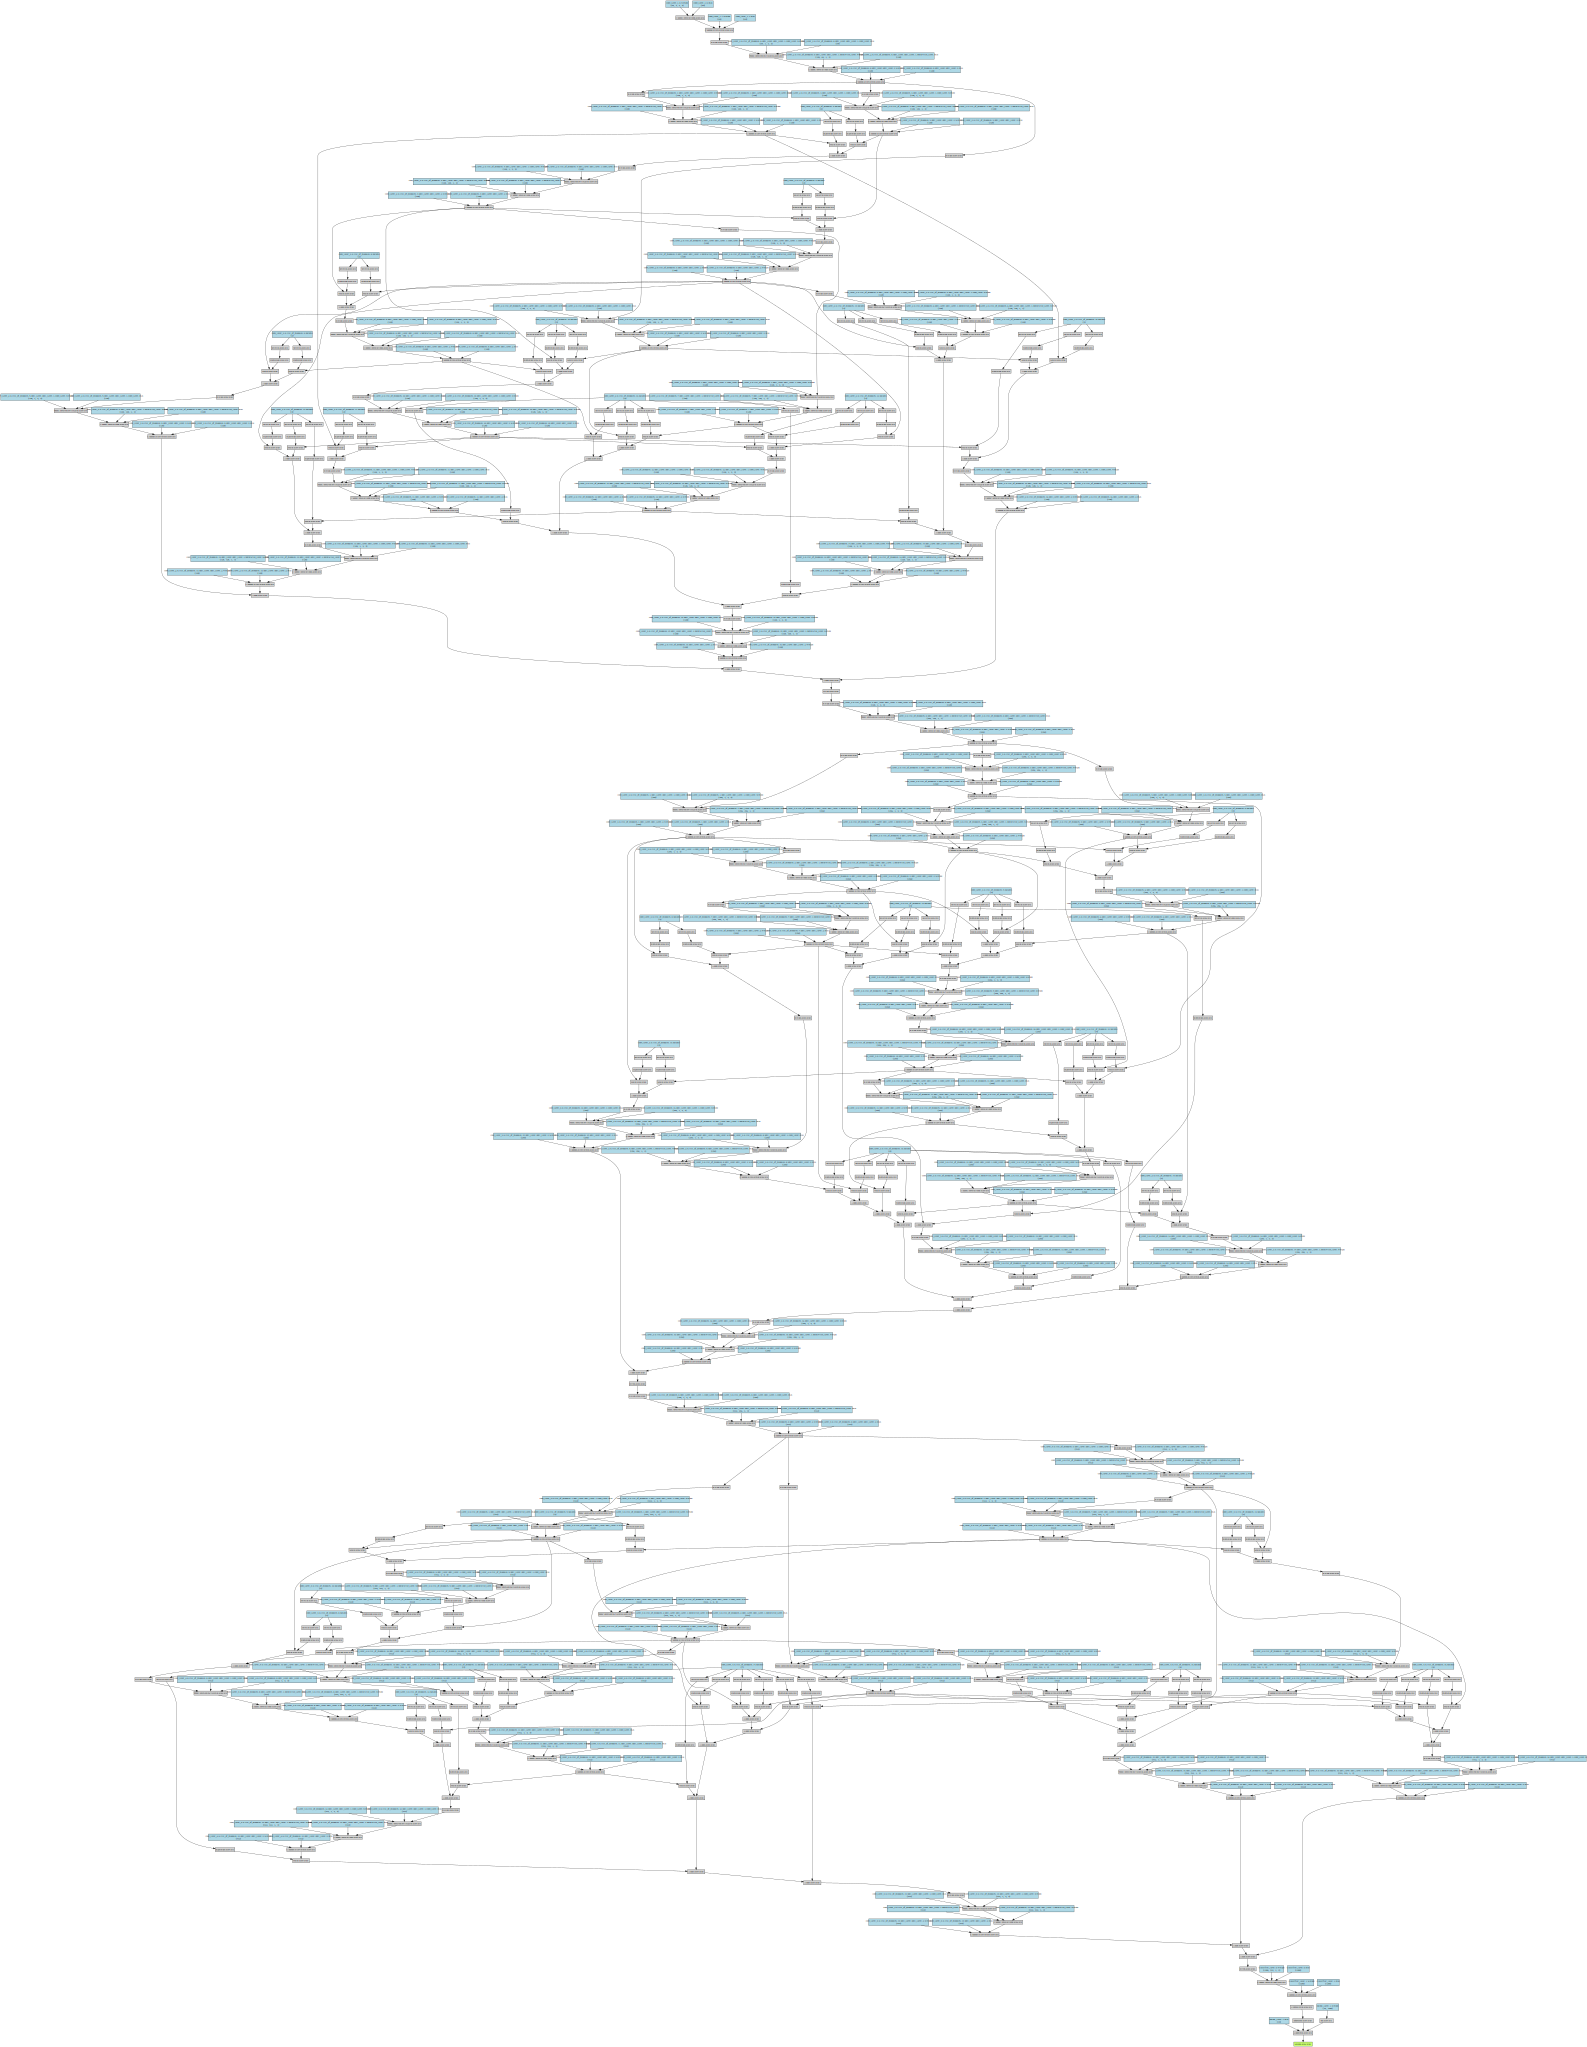

In [21]:
g